In [2]:
%matplotlib notebook
import numpy as np
import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
# Imports
from scipy.stats.stats import pearsonr
from scipy import signal
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from fastdtw import fastdtw
from mjc import MJC

from scipy.signal import savgol_filter
from sklearn.metrics import pairwise_distances
from scipy.ndimage.filters import gaussian_filter
from scipy.misc import imresize
from functools import partial
from scipy.spatial.distance import correlation, euclidean, pdist, canberra
from sklearn.externals.joblib import Parallel, delayed, cpu_count
from sklearn.utils import gen_even_slices

from skimage.measure import block_reduce

from time import time, sleep
from roipoly import roipoly
#Shape of the data
height = 256
width = 256

#28.815 and 86.5576
#90.14531424656546
TRUE_FRAMERATE = 28.815
IMAGING_FRAMERATE = 1/(34704.0/1e6)
SIGMA = 2


In [21]:
#AUTOMATIC EXPERIMENT SELECTOR
directory = "/media/gu4n1n3/Data3/2_mice/20180420/"
experiment = "Experiment_2/"


import os
from os.path import join, getsize
video_file = ''
timestamps_file = ''
subset_behaviour_file = ''
left_mouse_processed_file = ''
right_mouse_processed_file = ''
left_green_frame_file = ''
right_green_frame_file = ''
#LEGACY
combined_file = ''
for root, dirs, files in os.walk(directory+experiment):
    if "Behaviour" in root:
        for file in files:
            if 'timestamps' in file:
                timestamps_file = os.path.join(directory, experiment, root, file)
            elif 'subset' in file and 'raw' in file:
                subset_behaviour_file = os.path.join(directory, experiment, root, file)
            elif 'h264' in file:
                video_file = os.path.join(directory, experiment, root, file)
    else:
        for file in files:
            if '.mp4' not in file and 'png' not in file:
                if 'combined' in file and "raw" in file and 'upscaled' not in file:
                    if not 'gsr' in file:
                        if 'bandpass' in file:
                            combined_file = os.path.join(directory, experiment, root, file)
                #elif 'LEFT_GREEN_processed' in file and '0.01-12.0Hz' in file:
                elif 'LEFT_corrected_g_by_b' in file and '0.01-12.0Hz' in file:
                    left_mouse_processed_file = os.path.join(directory, experiment, root, file)
                elif 'RIGHT_corrected_g_by_b' in file and '0.01-12.0Hz' in file:
                #elif 'RIGHT_GREEN_processed' in file and '0.01-12.0Hz' in file:
                    right_mouse_processed_file = os.path.join(directory, experiment, root, file)
                elif 'LEFT_RAW_GREEN_FRAME' in file:
                    left_green_frame_file = os.path.join(directory, experiment, root, file)
                elif 'RIGHT_RAW_GREEN_FRAME' in file:
                    right_green_frame_file = os.path.join(directory, experiment, root, file)
             
date = left_mouse_processed_file.split("/")[5]
title = left_mouse_processed_file.split('/')[-1].split('.raw')[0]

print(date)
print(timestamps_file)
print(video_file)
print(subset_behaviour_file)
print(combined_file)
print(left_mouse_processed_file)
print(right_mouse_processed_file)
print(left_green_frame_file)
print(right_green_frame_file)

20180420
/media/gu4n1n3/Data3/2_mice/20180420/Experiment_2/Behaviour/M803L_M903R_April-20_1304_experiment-2_wt_non-cage-mates_first_meet_together_12mm_timestamps.raw
/media/gu4n1n3/Data3/2_mice/20180420/Experiment_2/Behaviour/M803L_M903R_April-20_1304_experiment-2_wt_non-cage-mates_first_meet_together_12mm.h264
/media/gu4n1n3/Data3/2_mice/20180420/Experiment_2/Behaviour/M803L_M903R_April-20_1304_experiment-2_wt_non-cage-mates_first_meet_together_12mm_subset_interpolated.raw

/media/gu4n1n3/Data3/2_mice/20180420/Experiment_2/LEFT_corrected_g_by_b_processed__interp_dff0_bandpass0.01-12.0Hz_MM803L_April-20_1304_experiment-2_M903R_wt_non-cage-mates_first_meet_together_12mm.raw
/media/gu4n1n3/Data3/2_mice/20180420/Experiment_2/RIGHT_corrected_g_by_b_processed__interp_dff0_bandpass0.01-12.0Hz_MM903R_April-20_1305_experiment-2_M803L_wt_non-cage-mates_first_meet_together_12mm.raw
/media/gu4n1n3/Data3/2_mice/20180420/Experiment_2/LEFT_RAW_GREEN_FRAME.npy
/media/gu4n1n3/Data3/2_mice/20180420/Exp

In [29]:
def get_processed_frames(filename, height, width):
    with open(filename, 'rb') as file:
        raw_frames = np.fromfile(file, dtype=np.float32)
        #raw_frames = raw_frames.byteswap(True)
        raw_frames = np.reshape(raw_frames, (int(raw_frames.shape[0]/(width*height)), height, width))
        print(np.shape(raw_frames))
        
    return raw_frames

def get_raw_behaviour_frames(video_file, height, width):
    with open(video_file, "rb") as file:
        raw_frames = np.fromfile(file, dtype=np.uint8)
        raw_frames = np.reshape(raw_frames, (int(raw_frames.shape[0]/(width*height)), height, width))
        print(np.shape(raw_frames))
        
        
    return raw_frames[:, :, :]

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


def get_global_signal(masked_frames):
    mean_g = np.mean(masked_frames, axis=1)
    g_plus = np.squeeze(np.linalg.pinv([mean_g]))
    mean_g = np.expand_dims(mean_g, axis=1)
    g_plus = np.expand_dims(g_plus, axis=0)
    beta_g = np.matmul(g_plus, masked_frames)
    
    print("Masked Frames: ", np.shape(masked_frames))
    print("MeanG: ", np.shape(mean_g))
    print("GPlus: ", np.shape(g_plus))
    print("Betag: ", np.shape(beta_g))
    
    global_signal = np.matmul(mean_g, beta_g)
    print("Global_sig: ", np.shape(global_signal))
        
    return global_signal, mean_g, beta_g
    
          
def gsr(frames, mask):
    
    mask=mask==255
    mask=np.reshape(mask,mask.shape[0]*mask.shape[1])
    indices = np.where((mask == True))
    indices=np.asarray(indices)
    
    brain_frames = np.zeros((frames.shape[0], indices.shape[1]))

    frames = np.reshape(frames, (frames.shape[0], frames.shape[1]*frames.shape[2]))
    brain_frames[:, :] = np.squeeze(frames[:, indices])
    #for i in range(frames.shape[0]):
    #    brain_frames[i, :] = frames[i, indices]



    mean_g = np.mean(brain_frames, axis=1)
    g_plus = np.squeeze(np.linalg.pinv([mean_g]))

    beta_g = np.dot(g_plus, frames)
    
    print(np.shape(mean_g))
    print(np.shape(beta_g))
    global_signal = np.dot(np.asarray([mean_g]).T, [beta_g])
    frames = frames - global_signal
    frames = np.reshape(frames, (frames.shape[0], width, height))
    return frames,mean_g

def calculate_correlation_map_of_slice(slice_frames, seed):
    slice_map = np.zeros((slice_frames.shape[1]))
    for i in range(slice_frames.shape[1]):
        slice_map[i] = correlation(slice_frames[:, i], seed)

    return slice_map

def calculate_correlation_map(FRAMES, seed, n_jobs=1):
    #height = FRAMES.shape[1]
    #width = FRAMES.shape[2]
    #FRAMES = FRAMES.reshape(FRAMES.shape[0], FRAMES.shape[1]*FRAMES.shape[2])

    if n_jobs < 0:
        n_jobs = max(cpu_count() + 1 + n_jobs, 1)
        
    fd = delayed(calculate_correlation_map_of_slice)
    ret = Parallel(n_jobs=n_jobs, verbose=0)(
        fd(FRAMES[:, s], seed)
        for s in gen_even_slices(FRAMES.shape[1], n_jobs))

    return np.hstack(ret)#.reshape(height, width)  

  
def calculate_pairwise_distances_video(FRAMES, all_masks, metric=correlation):
    print("Using metric method: ", metric.__name__)
    total_seeds = np.zeros_like(all_masks)[all_masks].shape[0]
    #distance_array = np.zeros((total_seeds, total_seeds))
    masked_frames = FRAMES[:, all_masks]
    
    #for s in range(total_seeds):
    #    print(s, "out of: ", total_seeds)
        #distance_array[s] = calculate_correlation_map(masked_frames[:], masked_frames[:, s], -1)
    #distance_array  = pdist(masked_frames.T, metric=metric)
    distance_array = pairwise_distances(masked_frames.T, metric=metric, n_jobs=-1)
    
    return distance_array
    
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y
  
def butter_bandpass(cutoff_low, cutoff_high, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff_low = cutoff_low / nyq
    normal_cutoff_high = cutoff_high / nyq
    Wn = [normal_cutoff_low, normal_cutoff_high]
    b, a = signal.butter(order, Wn, btype='bandpass', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff_low, cutoff_high, fs, order=5):
    b, a = butter_bandpass(cutoff_low, cutoff_high, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y
  

def downsample(arr, new_shape):
    """Rebin 2D array arr to shape new_shape by averaging."""
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)



In [ ]:
import scipy.io as sio


In [ ]:
l_dict = {}
r_dict = {}

l_dict['left_mouse'] = left_mouse_frames.astype(np.float32)
r_dict['right_mouse'] = right_mouse_frames.astype(np.float32)

In [ ]:
sio.savemat("/media/gu4n1n3/Data3/left_mouse_%s"%date, l_dict)
sio.savemat("/media/gu4n1n3/Data3/right_mouse_%s"%date, r_dict)

In [ ]:
test = sio.loadmat('/media/gu4n1n3/Data3/con_mouse33.mat')

In [ ]:
test?

In [ ]:
out1 = test['out1']
out2 = test['out2']
print(out1.shape)

In [ ]:
out1[np.where(np.isnan(out1))] = 0
out2[np.where(np.isnan(out2))] = 0

In [ ]:
out1_max = np.max(out1, axis=0)
out2_max = np.max(out2, axis=0)
print(np.shape(out1_max))

out1_new = out1/out1_max
out2_new = out2/out2_max
print(out1_new.shape)

In [ ]:
plt.figure()
test_frame = np.zeros((64, 64))

test_frame[~left_mouse_mask] = -10
test_frame[left_mouse_mask] = out1[100, left_mouse_mask]
plt.subplot(121)
plt.imshow(out1[35], vmin=0, vmax=25)

test_frame[~right_mouse_mask] = -10
test_frame[right_mouse_mask] = out2[100, right_mouse_mask]
plt.subplot(122)
plt.imshow(out2[34], vmin=0, vmax=25)

In [ ]:
plt.figure()
plt.subplot(211)
plt.plot(np.mean(out1[:, left_mouse_mask], axis=1), color='b')
plt.plot(np.mean(out2[:, right_mouse_mask], axis=1), color='r')
plt.subplot(212)
plt.plot(np.mean(out1[:, left_mouse_mask], axis=1)+np.mean(out2[:, right_mouse_mask], axis=1), color='k')

In [ ]:
plt.figure()
#plt.imshow(out1[2], vmin=0, vmax=15)
plt.plot()
#plt.plot(np.mean(np.mean(out2, axis=1), axis=1), color='r')
#plt.plot(np.mean(np.mean(out1, axis=1), axis=1), color='b')

In [ ]:
# Just the global signals, calcium and behaviour
video_frame = np.zeros((64, 64))
video_frame[:] = -10
video_frame2 = np.zeros((64, 64))
video_frame2[:] = -10

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=directory+experiment, artist='Fed',
                comment='30Hz_playback')
writer = FFMpegWriter(fps=5, metadata=metadata, bitrate=6000)
fig = plt.figure(figsize=(8, 8))
#sns.set_style('white')

ax_left_ca = fig.add_subplot(1, 2, 1)
ax_left_ca.set_title("Left Mouse Ca SECRET ANALYSIS")
ax_left_ca.get_yaxis().set_visible(False)
ax_left_ca.get_xaxis().set_visible(False)
left_ca_im = ax_left_ca.imshow(out1[0], cmap='viridis', vmin=0, vmax=1)
cbar3 = fig.colorbar(left_ca_im)

ax_right_ca = fig.add_subplot(1, 2, 2)
ax_right_ca.set_title("Right Mouse SECRET ANALYSIS")
ax_right_ca.get_yaxis().set_visible(False)
ax_right_ca.get_xaxis().set_visible(False)
right_ca_im = ax_right_ca.imshow(out2[0], cmap='viridis', vmin=0, vmax=1)
cbar4 = fig.colorbar(right_ca_im)




#sns.set_style('darkgrid')


print("Writing frames...")
with writer.saving(fig, "/media/gu4n1n3/Data3/SECRET_ANALYSIS.mp4", 100):
    for i in range(out1.shape[0]):
        # Set title
        plt.suptitle("Frame %s/%s" %(str(i+1), str(out1.shape[0])))
        #._title("Frame %s/%s" %(str(i), str(global_signal_left.shape[0])))
        
        frame = np.copy(out1_new[i])
        left_ca_im.set_data(frame)
        
        frame = np.copy(out2_new[i])
        right_ca_im.set_data(frame)
        writer.grab_frame()

print("Done!")

# Load the raw green frames for masking!

In [23]:
left_green_frame = downsample(np.load(left_green_frame_file), (64, 64))
right_green_frame = downsample(np.load(right_green_frame_file), (64, 64))

# Load Calcium Imaging and Gaussian Filter

In [12]:
# Old Combined Way
combined_frames = get_processed_frames(combined_file, 256, 512)
resized_combined_frames = np.zeros((combined_frames.shape[0], 64, 128))

for i, frame in enumerate(combined_frames):
    combined_frames[i] = gaussian_filter(combined_frames[i], SIGMA)
    resized_combined_frames[i] = downsample(frame, (64, 128))
    
print(np.shape(resized_combined_frames))

FileNotFoundError: [Errno 2] No such file or directory: ''

In [13]:
left_mouse_frames = combined_frames[:, :, :64]
right_mouse_frames = combined_frames[:, :, 64:]

NameError: name 'combined_frames' is not defined

# Separate Left Mouse and Right Mouse

In [32]:
# Separated mice loading
left_mouse_frames = get_processed_frames(left_mouse_processed_file, 256, 256)
left_mouse_frames[np.where(left_mouse_frames == -np.inf)] = -1
downsampled_left_mouse_frames = np.zeros((left_mouse_frames.shape[0], 64, 64))

right_mouse_frames = get_processed_frames(right_mouse_processed_file, 256, 256)
right_mouse_frames[np.where(right_mouse_frames==-np.inf)] = -1
downsampled_right_mouse_frames = np.zeros((right_mouse_frames.shape[0], 64, 64))

for i in range(left_mouse_frames.shape[0]):
    left_mouse_frames[i] = gaussian_filter(left_mouse_frames[i], SIGMA)                                      
    downsampled_left_mouse_frames[i] = downsample(left_mouse_frames[i], (64, 64))
                                          
    right_mouse_frames[i] = gaussian_filter(right_mouse_frames[i], SIGMA)                                      
    downsampled_right_mouse_frames[i] = downsample(right_mouse_frames[i], (64, 64))
    
print(np.shape(downsampled_left_mouse_frames))
print(np.shape(downsampled_right_mouse_frames))


(10084, 256, 256)
(10084, 256, 256)
(10084, 64, 64)
(10084, 64, 64)


In [34]:
left_mouse_frames = downsampled_left_mouse_frames
right_mouse_frames = downsampled_right_mouse_frames

# Load Behaviour Video

In [26]:
behaviour_frames = get_raw_behaviour_frames(subset_behaviour_file, 180, 320)


(10084, 180, 320)


# Masking of Brains

In [ ]:
plt.figure()
plt.imshow(combined_frames[2500], vmin=-.05, vmax=0.25)
LM_left_hem = roipoly(roicolor='b')


In [ ]:
plt.figure()
plt.imshow(combined_frames[2500], vmin=-.05, vmax=0.25)
LM_left_hem.displayROI()
LM_right_hem = roipoly(roicolor='r')

In [ ]:
plt.figure()
plt.imshow(combined_frames[1660], vmin=-.05, vmax=0.15)
LM_left_hem.displayROI()
LM_right_hem.displayROI()
RM_left_hem = roipoly(roicolor='b')

In [ ]:
plt.figure()
plt.imshow(combined_frames[2600], vmin=-.05, vmax=0.15)
LM_left_hem.displayROI()
LM_right_hem.displayROI()
RM_left_hem.displayROI()
RM_right_hem = roipoly(roicolor='r')

# Masking of separated frames

<IPython.core.display.Javascript object>


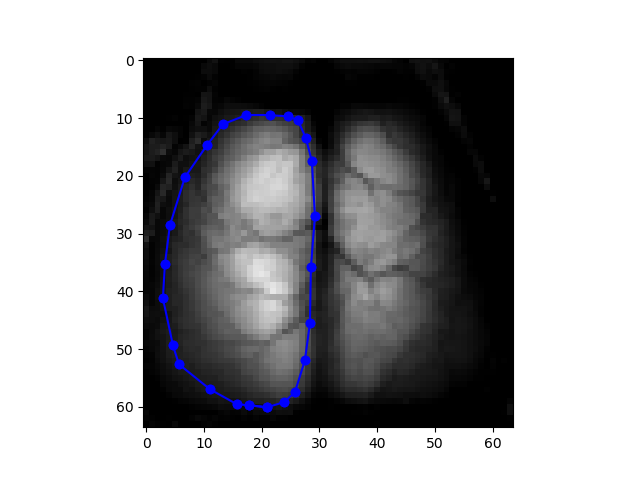

In [10]:
plt.figure()
plt.imshow(left_green_frame, cmap='gray', vmin=0, vmax=150)
LM_left_hem = roipoly(roicolor='b')

<IPython.core.display.Javascript object>


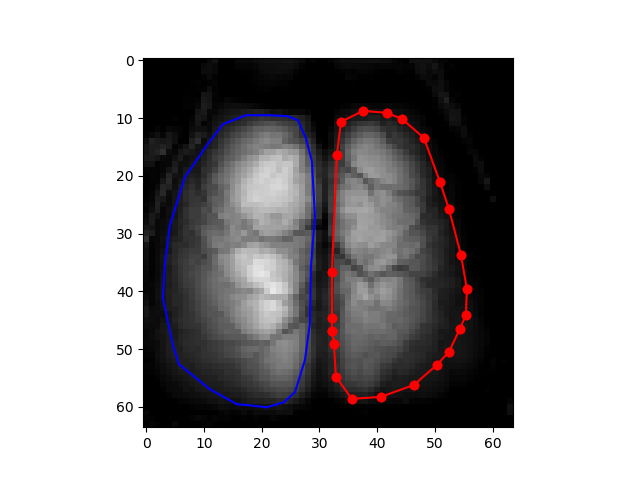

In [11]:
plt.figure()
plt.imshow(left_green_frame, cmap='gray', vmin=0, vmax=150)
LM_left_hem.displayROI()
LM_right_hem = roipoly(roicolor='r')

<IPython.core.display.Javascript object>


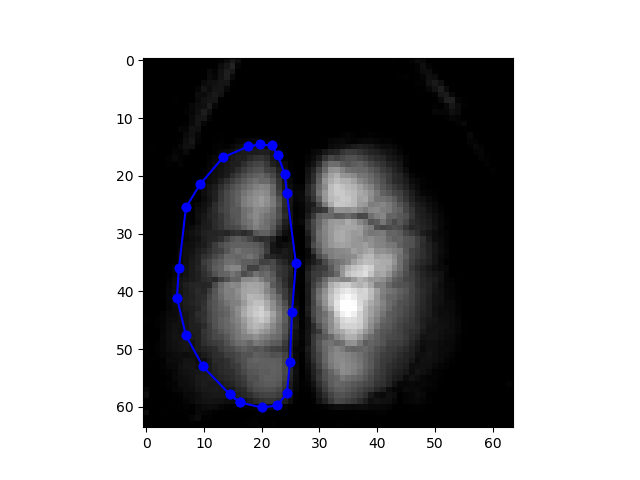

In [12]:
plt.figure()
plt.imshow(right_green_frame, cmap='gray', vmin=0, vmax=150)
RM_left_hem = roipoly(roicolor='b')

<IPython.core.display.Javascript object>


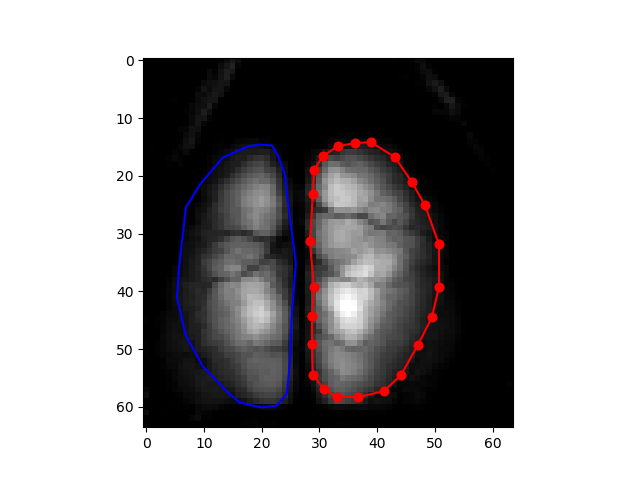

In [13]:
plt.figure()
plt.imshow(right_green_frame, cmap='gray', vmin=0, vmax=150)
RM_left_hem.displayROI()
RM_right_hem = roipoly(roicolor='r')

<IPython.core.display.Javascript object>


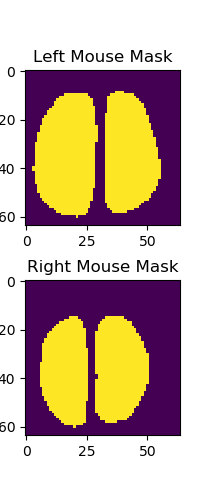

In [14]:
plt.figure(figsize=(2, 5))

left_mouse_mask = np.logical_or(LM_left_hem.getMask(left_mouse_frames[2000]), LM_right_hem.getMask(left_mouse_frames[2000]))
right_mouse_mask = np.logical_or(RM_left_hem.getMask(right_mouse_frames[2000]), RM_right_hem.getMask(right_mouse_frames[2000]))
plt.subplot(2, 1, 1)
plt.title("Left Mouse Mask")
plt.imshow(left_mouse_mask)
plt.subplot(2, 1, 2)
plt.title("Right Mouse Mask")
plt.imshow(right_mouse_mask)


In [86]:
try:
    np.save(directory+experiment+"all_maps.npy", all_masks)
except:
    print("There was no all_masks file, double check.")
np.save(directory+experiment+"LM_mask.npy", left_mouse_mask)
np.save(directory+experiment+"RM_mask.npy", right_mouse_mask)


# Load old mask

<IPython.core.display.Javascript object>


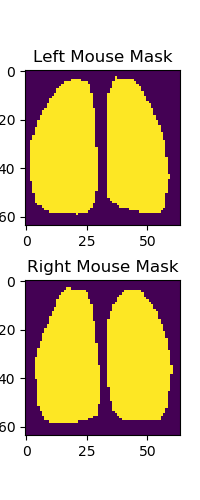

In [27]:
#all_masks = np.load(directory+experiment+"all_maps.npy")
left_mouse_mask = np.load(directory+experiment+"LM_mask.npy")
right_mouse_mask = np.load(directory+experiment+"RM_mask.npy")
all_masks = np.zeros((64, 128), dtype=np.bool)
all_masks[:, :64] = left_mouse_mask
all_masks[:, 64:] = right_mouse_mask
plt.figure(figsize=(2, 5))
plt.subplot(2, 1, 1)
plt.title("Left Mouse Mask")
plt.imshow(left_mouse_mask)
plt.subplot(2, 1, 2)
plt.title("Right Mouse Mask")
plt.imshow(right_mouse_mask)

# Calculate Global Signal

In [35]:
global_signal_left, L_mean_g, L_beta_g = get_global_signal(left_mouse_frames[:, left_mouse_mask])
global_signal_right, R_mean_g, R_beta_g = get_global_signal(right_mouse_frames[:, right_mouse_mask])

left_mouse_frames[:, left_mouse_mask] = left_mouse_frames[:, left_mouse_mask] - global_signal_left
right_mouse_frames[:, right_mouse_mask] = right_mouse_frames[:, right_mouse_mask] - global_signal_right

#L_mean_g = np.gradient(L_mean_g[:, 0])[:, None]
#R_mean_g = np.gradient(R_mean_g[:, 0])[:, None]


Masked Frames:  (10084, 2414)
MeanG:  (10084, 1)
GPlus:  (1, 10084)
Betag:  (1, 2414)
Global_sig:  (10084, 2414)
Masked Frames:  (10084, 2390)
MeanG:  (10084, 1)
GPlus:  (1, 10084)
Betag:  (1, 2390)
Global_sig:  (10084, 2390)


In [38]:
left_mouse_frames[:, ~left_mouse_mask] = -100
right_mouse_frames[:, ~right_mouse_mask] = -100

left_mouse_frames.astype(np.float32).tofile(directory+experiment+"left_mouse_gsr_frames.raw")
right_mouse_frames.astype(np.float32).tofile(directory+experiment+"right_mouse_gsr_frames.raw")


In [37]:
print(np.shape(left_mouse_frames))

(10084, 64, 64)


# Replace combined by the GS of the mice

In [ ]:
left_mouse_frames[:, ~left_mouse_mask] = -100
left_mouse_frames[:, left_mouse_mask] = global_signal_left

right_mouse_frames[:, ~right_mouse_mask] = -100
right_mouse_frames[:, right_mouse_mask] = global_signal_right

combined_frames = np.zeros((left_mouse_frames.shape[0], 64, 128))
combined_frames[:, :, :64] = left_mouse_frames
combined_frames[:, :, 64:] = right_mouse_frames

In [ ]:
combined_frames.tofile(directory+experiment+"gsr_testing.raw")

# Plot mean global signal across space

<IPython.core.display.Javascript object>


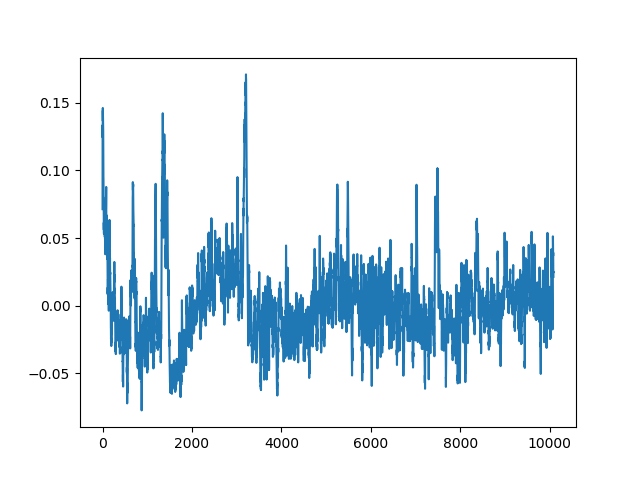

0.000696666519284


In [10]:
plt.figure()
plt.plot(L_mean_g[:, 0])
print(np.mean(L_mean_g))

In [ ]:
plt.figure()
image = np.zeros((64, 64))
image[right_mouse_mask] = R_beta_g[0,:]
plt.imshow(image, vmin=0, vmax=1.7)


In [ ]:
plt.figure(figsize=(8, 8))

start_interaction = 2938#6240#2938 
end_interaction = 6980#12853#6980

start_interaction = np.round(float(start_interaction)/IMAGING_FRAMERATE, 3)
end_interaction = np.round(float(end_interaction)/IMAGING_FRAMERATE, 3)

plt.suptitle("Spectrogram for experiment:\n %s"%(title))
fs = IMAGING_FRAMERATE
f, t, Sxx = signal.spectrogram(L_mean_g[:, 0], fs, nfft=2048, nperseg=2048)
ax1 = plt.subplot(211)
plt.title("Left Mouse")
plt.pcolormesh(t, f, (Sxx), cmap='viridis', vmin=0.0, vmax=0.015)
#plt.axvspan(start_interaction, end_interaction, color='w', alpha=0.1, label='Mice Together')
plt.axvline(start_interaction, color='k', linewidth=1.0, alpha=0.6, label='Mice Together')
plt.axvline(end_interaction, color='k', linewidth=1.0, alpha=0.6, label='Mice Together')
plt.colorbar()
plt.ylim([0, 1])
plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')
plt.setp(ax1.get_xticklabels(), visible=False)


f, t, Sxx = signal.spectrogram(R_mean_g[:, 0], fs, nfft=2048, nperseg=2048)
plt.subplot(212)
plt.title("Right Mouse")
plt.pcolormesh(t, f, (Sxx), cmap='viridis', vmin=0.0, vmax=0.015)
#plt.axvspan(start_interaction, end_interaction, color='w', alpha=0.1, label='Mice Together')

plt.axvline(start_interaction, color='k', linewidth=1.0, alpha=0.6, label='Mice Together')
plt.axvline(end_interaction, color='k', linewidth=1.0, alpha=0.6, label='Mice Together')
plt.colorbar()
plt.ylim([0, 1])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.savefig(directory+experiment+title+"_spectrogram.png")

In [ ]:
signal.spectrogram?

<IPython.core.display.Javascript object>


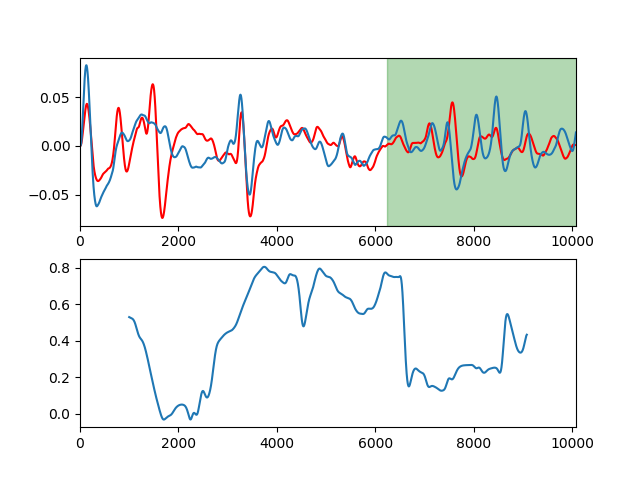

(10083, 1960)


In [19]:
plt.figure()
#test =np.zeros((64, 128))
#test[all_masks] = combined_frames[1660, all_masks]
#plt.imshow(test, vmin=0, vmax=0.15)

#a = (combined_frames[:, all_masks])[:, 0]
order=3
fs=IMAGING_FRAMERATE
cutoff_low=0.01
cutoff_high=0.1
#b, a = butter_lowpass(cutoff, fs, order)

s1 = butter_bandpass_filter(np.mean(global_signal_left[:, :], axis=1), cutoff_low, cutoff_high, fs, order)
s2 = butter_bandpass_filter(np.mean(global_signal_right[:, :], axis=1), cutoff_low, cutoff_high, fs, order)



#s1 = np.mean(global_signal_left[:, :], axis=1)
#s2 = np.mean(global_signal_right[:, :], axis=1)
#plt.plot(a)
#plt.plot(b)
window_size = 2000
corrs = []
for i in range(len(s1)-window_size):
    corrs.append(1-correlation(s1[i:i+window_size], s2[i:i+window_size]))
    #corrs.append(euclidean(s1[i:i+window_size], s2[i:i+window_size]))
    
start_interaction = 6240
end_interaction = 12853
plt.subplot(211)
plt.plot(s1, 'r')
plt.plot(s2)
plt.axvspan(start_interaction, end_interaction, color='g', alpha=0.3, label='Duration of Togetherness')
plt.xlim(0, len(s1))
plt.subplot(212)
lol = 200
corr_x_axis = np.linspace(window_size/2, len(s1)-window_size/2, len(corrs))
#corrs = running_mean(corrs, lol)
plt.plot(corr_x_axis, corrs)
plt.xlim([0, len(s1)])
print(np.shape(global_signal_left))

In [ ]:
# Plot the global signals alone to show the synchronization
import seaborn as sns
sns.set()
exp_duration = len(s1)/IMAGING_FRAMERATE
time_axis = np.linspace(0, exp_duration, len(s1))
start_interaction = 2962/IMAGING_FRAMERATE
end_interaction = 6950/IMAGING_FRAMERATE
plt.figure(figsize=(16, 8))
plt.title("Global signals of a together experiment filtered at %s-%sHz" %(str(cutoff_low), str(cutoff_high)))
plt.plot(time_axis, s1, linewidth=1.0, color='b', label='Left Mouse')
plt.plot(time_axis, s2, linewidth=1.0, color='r', label='Right Mouse')
plt.axvspan(start_interaction, end_interaction, color='g', alpha=0.3, label='Duration of Togetherness')
plt.ylabel(r'Corrected $\frac{\Delta F}{F_0}$', size=20)
plt.xlabel('Time(s)', size=20)
plt.legend()

In [12]:
#frequency_bands = np.linspace(0.01, 12.0, 100)
frequency_bands = [0.01, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 6.0, 8.0, 10.0, 12.0]
#frequency_bands = [0.01, 0.05, 1.5]
window_size = 3800
fs=IMAGING_FRAMERATE
order=3
total_bins = global_signal_left.shape[0]-window_size
cool_image = np.zeros((len(frequency_bands)-1, total_bins))
og_s1 = np.copy(L_mean_g[:, 0])#np.mean(global_signal_left[:, :], axis=1)
og_s2 = np.copy(R_mean_g[:, 0])#np.mean(global_signal_right[:, :], axis=1)
frequency_labels = []
for i in range(len(frequency_bands)-1):
    
    print(frequency_bands[i], frequency_bands[i+1])
    frequency_labels.append(str(frequency_bands[i])+'-'+str(frequency_bands[i+1])+'Hz')
    s1 = butter_bandpass_filter(og_s1, frequency_bands[i], frequency_bands[i+1], fs, order)    
    s2 = butter_bandpass_filter(og_s2, frequency_bands[i], frequency_bands[i+1], fs, order)

    for j in range(len(s1)-window_size):
        cool_image[i, j] = (1-correlation(s1[j:j+window_size], s2[j:j+window_size]))
        
    
np.save(directory+experiment+"GFP_frequency_split_correlation_filtered_ws=%s.py"%str(window_size), cool_image)


    

0.01 0.1
0.1 0.5
0.5 1.0
1.0 2.0
2.0 3.0
3.0 4.0
4.0 6.0
6.0 8.0
8.0 10.0
10.0 12.0


<IPython.core.display.Javascript object>


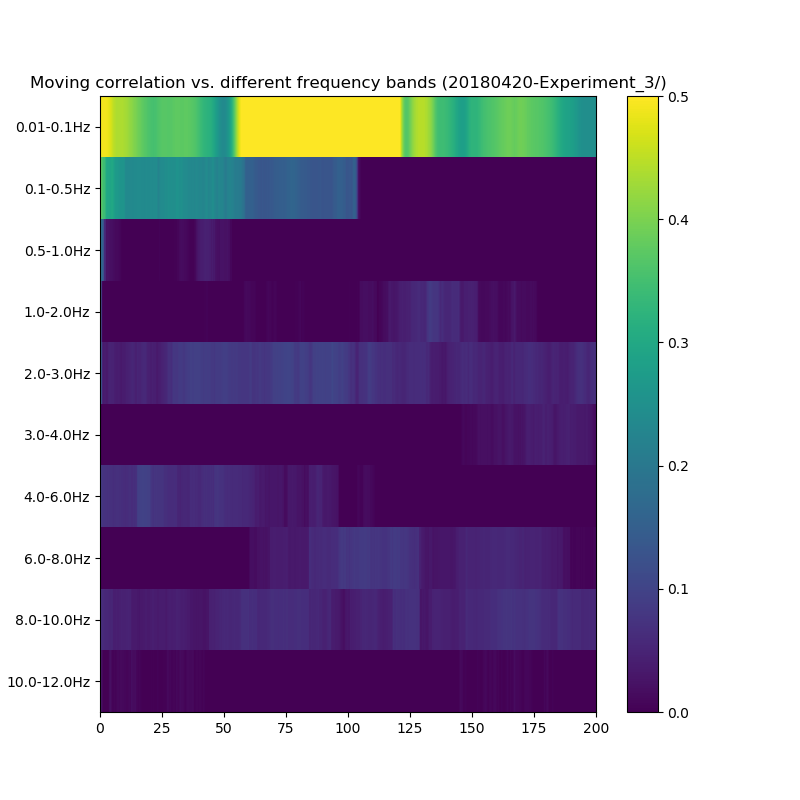

In [13]:
plt.figure(figsize=(8, 8))
#sns.set_style('white')
plt.title("Moving correlation vs. different frequency bands (%s-%s)"%(date, experiment))
y_ticks = np.arange(cool_image.shape[0])+0.5
y_ticks = np.flipud(y_ticks)
plt.imshow(cool_image, cmap='viridis', extent=[0,200,0,10], aspect='auto', vmin=0.0, vmax=.5)
plt.yticks(y_ticks, frequency_labels)
plt.colorbar()
plt.savefig(directory+experiment+"frequency_split_figure.svg")

# Shift the signals plot correlations

<IPython.core.display.Javascript object>


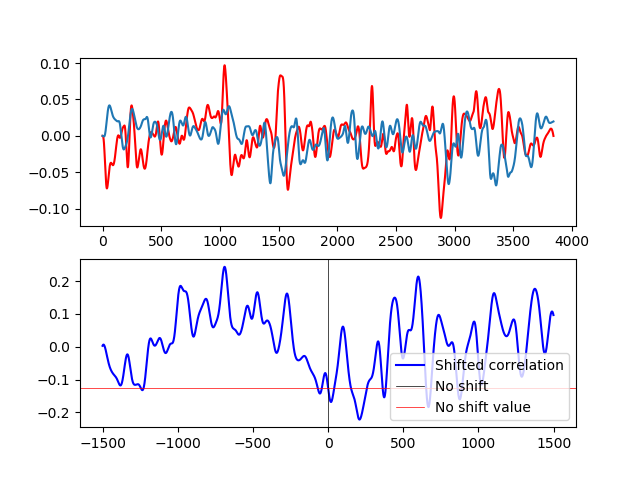

In [75]:
plt.figure()
order=3
fs=IMAGING_FRAMERATE
cutoff=0.5
interaction_start = 6240
interaction_end = 12853
corrs = []
shift_x = []

og_s1 = butter_lowpass_filter(np.mean(global_signal_left[interaction_start:interaction_end, :], axis=1), cutoff, fs, order)
og_s2 = butter_lowpass_filter(np.mean(global_signal_right[interaction_start:interaction_end, :], axis=1), cutoff, fs, order)
for i in range(-1500, 1500):
    s1 = np.copy(og_s1)
    s2 = np.copy(og_s2)

    '''
    Shift one signal over the other
    '''
    if i != 0:
        number_of_frames_to_shift = i
        tmp = np.copy(s2[:number_of_frames_to_shift])
        s2[:-number_of_frames_to_shift] = np.copy(s2[number_of_frames_to_shift:])
        s2[-number_of_frames_to_shift:] = tmp

    corrs.append(1-correlation(s1, s2))
    shift_x.append(i)
    
shift_x = np.asarray(shift_x)
corrs = np.asarray(corrs)
    
plt.subplot(211)
plt.plot(og_s1, 'r')
plt.plot(og_s2)
plt.subplot(212)
plt.plot(shift_x, corrs, color='b', label="Shifted correlation")
plt.axvline(0, color='k', linewidth=0.5, label="No shift")
plt.axhline(corrs[np.where(shift_x==0)][0], color='r', linewidth=0.5, label="No shift value")
plt.legend()


# Save global signal as video

In [ ]:
video_frame = np.zeros((64, 64))
video_frame[:] = -10
video_frame2 = np.zeros((64, 64))
video_frame2[:] = -10

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=directory+experiment, artist='Fed',
                comment='30Hz_playback')
writer = FFMpegWriter(fps=30, metadata=metadata)
fig = plt.figure(figsize=(20, 14))
#sns.set_style('white')
ax1 = fig.add_subplot(3, 4, 1)
ax1.set_title("Left Global Signal")
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
video_frame[left_mouse_mask] = global_signal_left[0]
im_map = ax1.imshow(video_frame, cmap='viridis', vmin=-0.05, vmax=0.07)
cbar = fig.colorbar(im_map)

ax3 = fig.add_subplot(3, 4, 2)
ax3.set_title("Right Global Signal")
ax3.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
video_frame2[right_mouse_mask] = global_signal_right[0]
im_map_2 = ax3.imshow(video_frame, cmap='viridis', vmin=-0.05, vmax=0.07)
cbar2 = fig.colorbar(im_map_2)

ax_left_ca = fig.add_subplot(3, 4, 5)
ax_left_ca.set_title("Left Mouse Ca Imaging")
ax_left_ca.get_yaxis().set_visible(False)
ax_left_ca.get_xaxis().set_visible(False)
left_ca_im = ax_left_ca.imshow(left_mouse_frames[0], cmap='viridis', vmin=-0.05, vmax=0.15)
cbar3 = fig.colorbar(left_ca_im)

ax_right_ca = fig.add_subplot(3, 4, 6)
ax_right_ca.set_title("Right Mouse Ca Imaging")
ax_right_ca.get_yaxis().set_visible(False)
ax_right_ca.get_xaxis().set_visible(False)
right_ca_im = ax_right_ca.imshow(right_mouse_frames[0], cmap='viridis', vmin=-0.05, vmax=0.15)
cbar4 = fig.colorbar(right_ca_im)

ax_global_signal = fig.add_subplot(3, 2, 2)
ax_global_signal.set_title("Global Signals filtered at %s-%sHz"%(str(cutoff_low), str(cutoff_high)))
ax_global_signal.set_ylabel(r'$\Delta F/F_0$')
ax_global_signal.set_xlabel('Time (frames)')
left_gs_plot = ax_global_signal.plot(s1, color='b', linewidth=0.5, label="Left GS")
right_gs_plot = ax_global_signal.plot(s2, color='r', linewidth=0.5, label="Right GS")
window_span = ax_global_signal.axvspan(0, window_size, alpha=0.3, color='g', label='Current Window')
now_line = ax_global_signal.axvline(window_size, color='k', linewidth=0.5, label='Current Frame')
ax_global_signal.legend(prop={'size': 6})

ax_corrs = fig.add_subplot(3, 2, 4)
ax_corrs.set_title("Sliding Correlation Plot (WindowSize=%s)"%str(window_size))
ax_corrs.set_ylabel("Correlation Coefficient")
ax_corrs.set_xlabel("Current Slice")
corrs_plot = ax_corrs.plot(corrs, color='b', label='Sliding Window Correlation')
now_line_corr = ax_corrs.axvline(window_size, color='r', linewidth=0.5, label='Current Correlation')
ax_corrs.legend(prop={'size': 6})

ax2 = fig.add_subplot(3, 1, 3)
ax2.set_title("Behaviour Camera")
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
behaviour_im = ax2.imshow(behaviour_frames[0], cmap='gray', vmin=0, vmax=180)




#sns.set_style('darkgrid')


print("Writing frames...")
with writer.saving(fig, directory+experiment+video_file.split("/")[-1]+"_GS_FRAMES_separate_low_clim.mp4", 100):
    for i, frame in enumerate(global_signal_left[window_size:]):
        # Set title
        plt.suptitle("Frame %s/%s" %(str(i+window_size), str(global_signal_left.shape[0])))
        #._title("Frame %s/%s" %(str(i), str(global_signal_left.shape[0])))
        video_frame[left_mouse_mask] = global_signal_left[i+window_size]
        im_map.set_data(video_frame)
        #im_map.set_clim(np.min(video_frame[left_mouse_mask]), np.max(video_frame[left_mouse_mask]))
        
        video_frame2[right_mouse_mask] = global_signal_right[i+window_size]
        im_map_2.set_data(video_frame2)
        
        frame = np.copy(left_mouse_frames[i+window_size])
        frame[~left_mouse_mask] = -10
        left_ca_im.set_data(frame)
        
        frame = np.copy(right_mouse_frames[i+window_size])
        frame[~right_mouse_mask] = -10
        right_ca_im.set_data(frame)
        #im_map_2.set_clim(np.min(video_frame2[right_mouse_mask]), np.max(video_frame2[right_mouse_mask]))
        window_span.remove()
        now_line.remove()
        now_line_corr.remove()
        window_span = ax_global_signal.axvspan(i, i+window_size, alpha=0.3, color='g', label='Current Corr Window')
        now_line = ax_global_signal.axvline(i+window_size, color='k', linewidth=0.5, label='Current Frame')
        now_line_corr = ax_corrs.axvline(i, color='r', linewidth=0.5, label='Current Correlation')
        ax_global_signal.set_xlim(i-window_size, min(i+2*window_size, global_signal_left.shape[0]))
        ax_corrs.set_xlim(i-100, min(i+100, len(corrs)))
        
        plt.draw()
        
        
        #ax_global_signal.axvspan(i, i+window_size, alpha=0.3, color='g', label='Current Window')
        #plt.axvspan(0, 29, alpha=0.3, color='r', label="Duration of stim")
        
        behaviour_im.set_data(behaviour_frames[i+window_size])
        #print(i//window_size)
        #print(combined_frames.shape[0]//(i*cluster_maps.shape[0])
        #int((combined_frames.shape[0]-window_size)/window_shift)+1
        writer.grab_frame()

print("Done!")

<IPython.core.display.Javascript object>


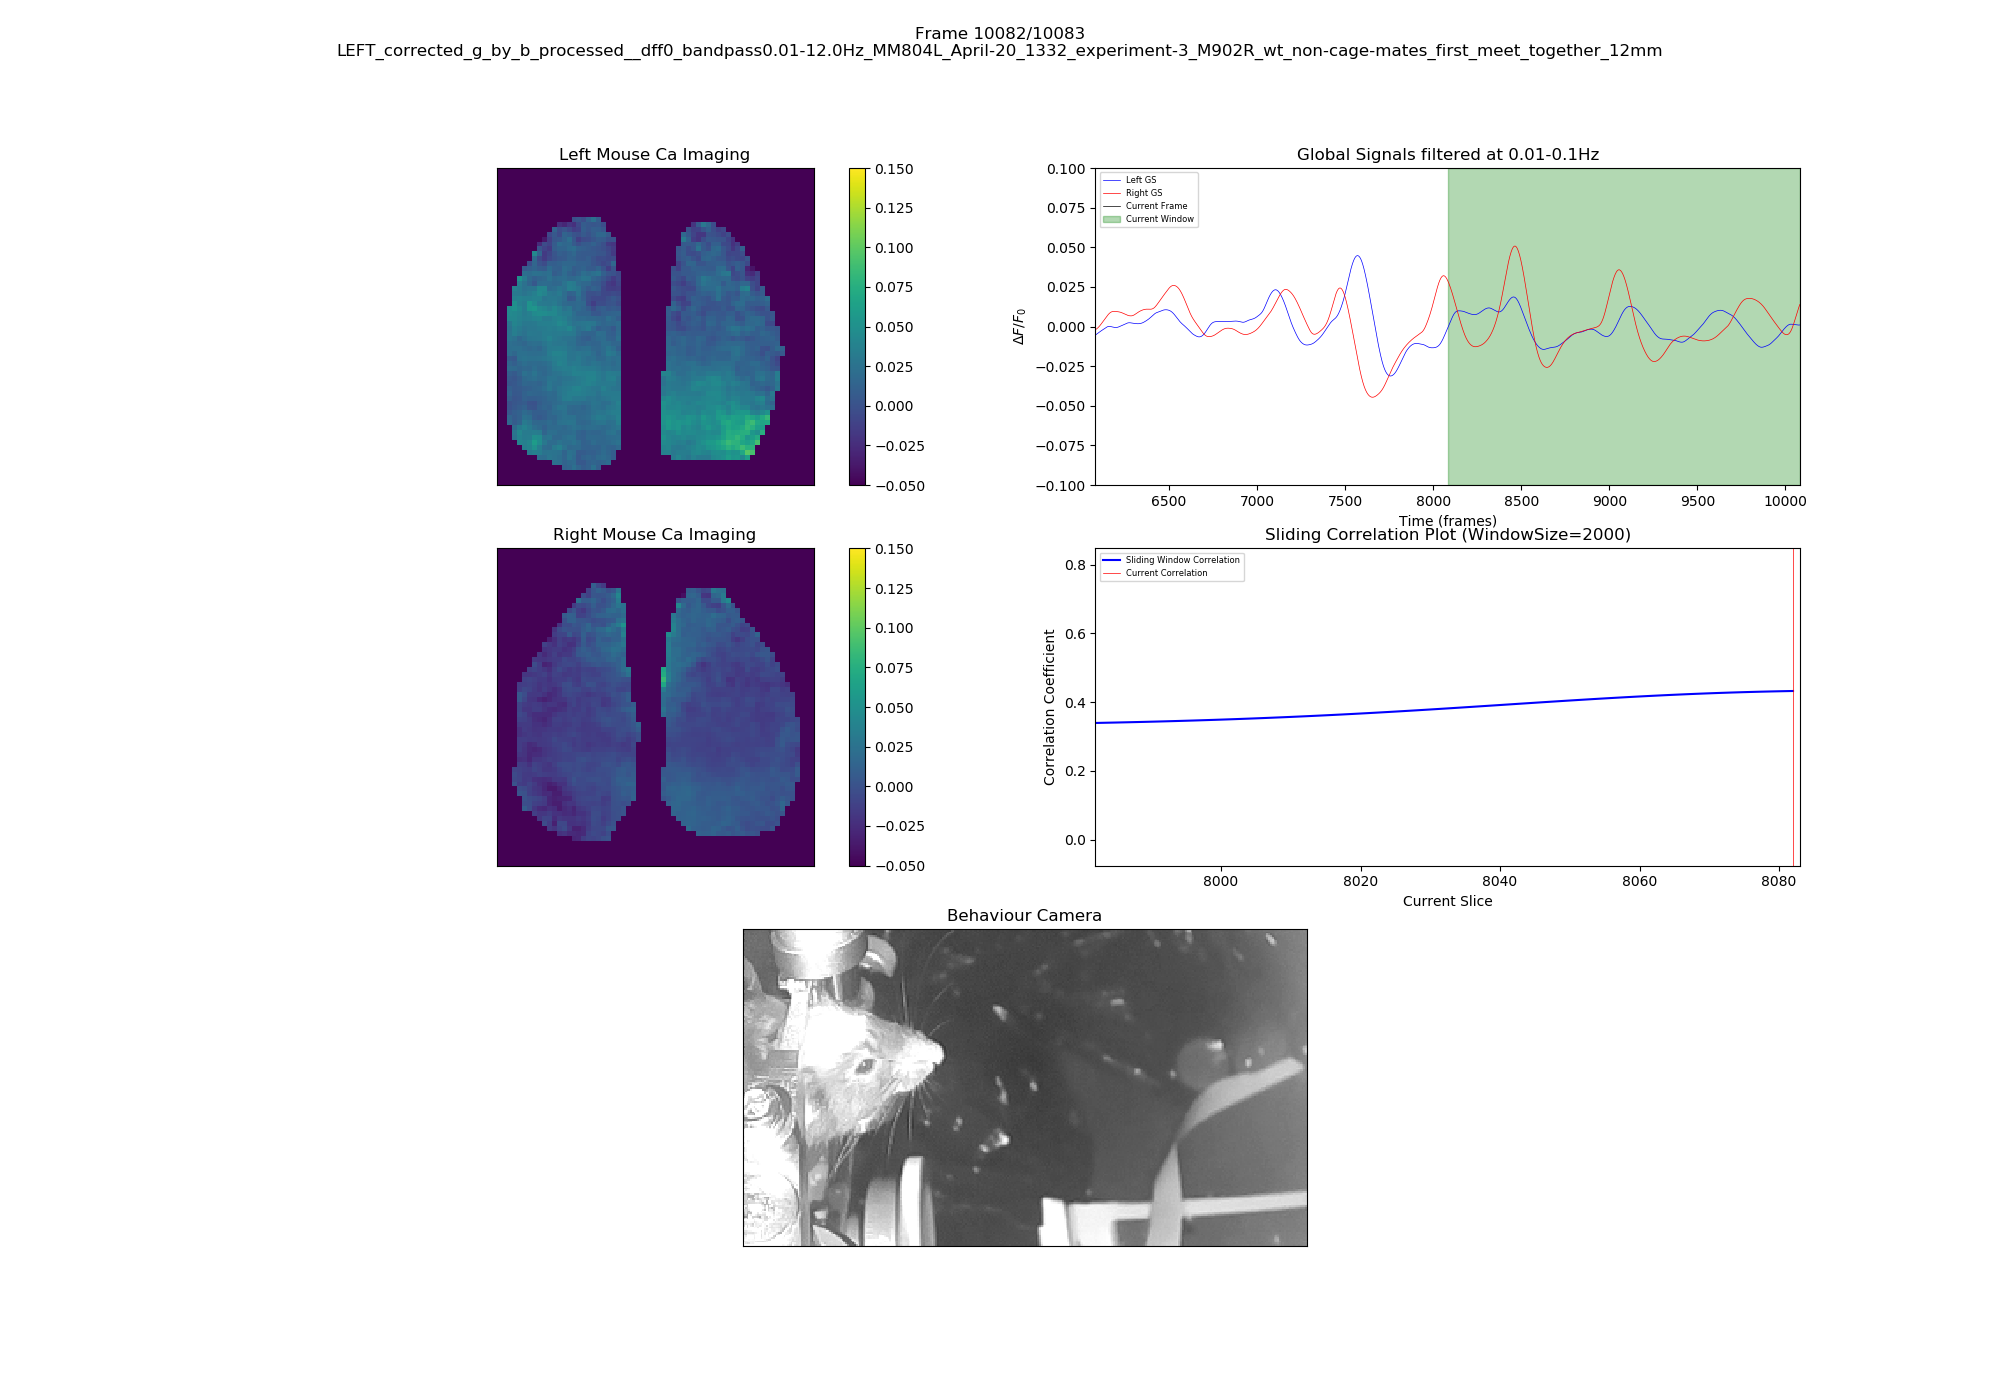

Writing frames...
Done!


In [20]:
# Just the global signals, calcium and behaviour
video_frame = np.zeros((64, 64))
video_frame[:] = -10
video_frame2 = np.zeros((64, 64))
video_frame2[:] = -10

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=directory+experiment, artist='Fed',
                comment='30Hz_playback')
writer = FFMpegWriter(fps=30, metadata=metadata, bitrate=2000)
fig = plt.figure(figsize=(20, 14))
#sns.set_style('white')

ax_left_ca = fig.add_subplot(3, 2, 1)
ax_left_ca.set_title("Left Mouse Ca Imaging")
ax_left_ca.get_yaxis().set_visible(False)
ax_left_ca.get_xaxis().set_visible(False)
left_ca_im = ax_left_ca.imshow(left_mouse_frames[0], cmap='viridis', vmin=-0.05, vmax=0.15)
cbar3 = fig.colorbar(left_ca_im)

ax_right_ca = fig.add_subplot(3, 2, 3)
ax_right_ca.set_title("Right Mouse Ca Imaging")
ax_right_ca.get_yaxis().set_visible(False)
ax_right_ca.get_xaxis().set_visible(False)
right_ca_im = ax_right_ca.imshow(right_mouse_frames[0], cmap='viridis', vmin=-0.05, vmax=0.15)
cbar4 = fig.colorbar(right_ca_im)

ax_global_signal = fig.add_subplot(3, 2, 2)
ax_global_signal.set_title("Global Signals filtered at %s-%sHz"%(str(cutoff_low), str(cutoff_high)))
ax_global_signal.set_ylabel(r'$\Delta F/F_0$')
ax_global_signal.set_xlabel('Time (frames)')
left_gs_plot = ax_global_signal.plot(s1, color='b', linewidth=0.5, label="Left GS")
right_gs_plot = ax_global_signal.plot(s2, color='r', linewidth=0.5, label="Right GS")
window_span = ax_global_signal.axvspan(0, window_size, alpha=0.3, color='g', label='Current Window')
now_line = ax_global_signal.axvline(window_size, color='k', linewidth=0.5, label='Current Frame')
ax_global_signal.legend(prop={'size': 6})

ax_corrs = fig.add_subplot(3, 2, 4)
ax_corrs.set_title("Sliding Correlation Plot (WindowSize=%s)"%str(window_size))
ax_corrs.set_ylabel("Correlation Coefficient")
ax_corrs.set_xlabel("Current Slice")
corrs_plot = ax_corrs.plot(corrs, color='b', label='Sliding Window Correlation')
now_line_corr = ax_corrs.axvline(window_size, color='r', linewidth=0.5, label='Current Correlation')
ax_corrs.legend(prop={'size': 6})

ax2 = fig.add_subplot(3, 1, 3)
ax2.set_title("Behaviour Camera")
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
behaviour_im = ax2.imshow(behaviour_frames[0], cmap='gray', vmin=0, vmax=255)




#sns.set_style('darkgrid')


print("Writing frames...")
with writer.saving(fig, directory+experiment+title+"_global_signals_filtered_at_%s-%sHz_window_correlation_ws=%s.mp4" %(str(cutoff_low), str(cutoff_high), str(window_size)), 100):
    for i, frame in enumerate(global_signal_left[window_size:]):
        # Set title
        plt.suptitle("Frame %s/%s\n%s" %(str(i+window_size), str(global_signal_left.shape[0]), title))
        #._title("Frame %s/%s" %(str(i), str(global_signal_left.shape[0])))
        
        frame = np.copy(left_mouse_frames[i+window_size])
        frame[~left_mouse_mask] = -100
        left_ca_im.set_data(frame)
        
        frame = np.copy(right_mouse_frames[i+window_size])
        frame[~right_mouse_mask] = -100
        right_ca_im.set_data(frame)
        #im_map_2.set_clim(np.min(video_frame2[right_mouse_mask]), np.max(video_frame2[right_mouse_mask]))
        window_span.remove()
        now_line.remove()
        now_line_corr.remove()
        window_span = ax_global_signal.axvspan(i, i+window_size, alpha=0.3, color='g', label='Current Corr Window')
        now_line = ax_global_signal.axvline(i+window_size, color='k', linewidth=0.5, label='Current Frame')
        now_line_corr = ax_corrs.axvline(i, color='r', linewidth=0.5, label='Current Correlation')
        ax_global_signal.set_xlim(i-window_size, min(i+2*window_size, global_signal_left.shape[0]))
        valid_slice_start = max(0, i-window_size)
        valid_slice_end = min(len(s1)-1, i+2*window_size)
        y_min_lim = min(-0.1, np.min(s1[valid_slice_start:valid_slice_end]), np.min(s2[valid_slice_start:valid_slice_end]))
        y_max_lim = max(0.1, np.max(s1[valid_slice_start:valid_slice_end]), np.max(s2[valid_slice_start:valid_slice_end]))
        ax_global_signal.set_ylim(y_min_lim, y_max_lim)
        ax_corrs.set_xlim(i-100, min(i+100, len(corrs)))
        
        plt.draw()
        
        
        #ax_global_signal.axvspan(i, i+window_size, alpha=0.3, color='g', label='Current Window')
        #plt.axvspan(0, 29, alpha=0.3, color='r', label="Duration of stim")
        
        behaviour_im.set_data(behaviour_frames[i+window_size])
        #print(i//window_size)
        #print(combined_frames.shape[0]//(i*cluster_maps.shape[0])
        #int((combined_frames.shape[0]-window_size)/window_shift)+1
        writer.grab_frame()

print("Done!")

In [ ]:
spcm = np.zeros(np.shape(all_masks))
masked_spcm = calculate_correlation_map(combined_frames[:,all_masks], combined_frames[:, 43, 72], -1)
print(np.shape(masked_spcm))
spcm[all_masks] = 1-masked_spcm
plt.imshow(spcm,vmin=0, vmax=1)

# Distances for the ENTIRE dataset

In [ ]:
# Watch out, takes a long time.
metric=euclidean
full_distance_array = calculate_pairwise_distances_video(combined_frames, all_masks, metric=metric)

# Generate video of ALL seed maps

In [ ]:
seed_map = np.zeros((64, 128))
seed_map[:] = -10

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=directory+experiment, artist='Fed',
                comment='10Hz_playback')
writer = FFMpegWriter(fps=10, metadata=metadata)
fig = plt.figure(figsize=(10, 8))
#sns.set_style('white')
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_title("All the seed maps! For fun!")
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
seed_map[all_masks] = full_distance_array[0]
im_map = ax1.imshow(seed_map, cmap='viridis', vmin=0, vmax=1)
cbar = fig.colorbar(im_map)
#sns.set_style('darkgrid')


print("Writing frames...")
with writer.saving(fig, directory+experiment+video_file.split("/")[-1]+"_all_seed_maps_metric-%s.mp4"%(metric.__name__), 100):
    for i, combined_frame in enumerate(full_distance_array):
        # Set title
        
        ax1.set_title("Seed Map %s/%s" %(str(i), str(full_distance_array.shape[0])))
        seed_map[all_masks] = 1-full_distance_array[i]
        im_map.set_data(seed_map)
        #print(i//window_size)
        #print(combined_frames.shape[0]//(i*cluster_maps.shape[0])
        #int((combined_frames.shape[0]-window_size)/window_shift)+1
        writer.grab_frame()

print("Done!")

# Cluster the entire dataset

In [ ]:
model = KMeans(n_clusters = 10, init='k-means++', precompute_distances=True, random_state=0, n_jobs=-1)
model.fit(distance_array)

In [ ]:
Z = model.predict(distance_array)
Z[np.where(Z==0)]=np.max(Z)+1
cluster_maps[d][all_masks] = Z

In [ ]:
clustered_map = np.zeros(all_masks.shape)
clustered_map[all_masks] = Z

In [ ]:
plt.imshow(clustered_map, cmap='rainbow')

# Cluster Windowed version of Dataset

In [ ]:
window_shift = 120 # how many frames to move each time
window_size = 2800
metric = euclidean
#fastdtw, dist=euclidean

total_seeds = np.zeros_like(all_masks)[all_masks].shape[0]
windowed_distance_array = np.zeros((int((combined_frames.shape[0]-window_size)/window_shift)+1, total_seeds, total_seeds))

print(np.shape(windowed_distance_array))
for i in range(int((combined_frames.shape[0]-window_size)/window_shift)+1):
    windowed_distance_array[i] = calculate_pairwise_distances_video(combined_frames[i*window_shift:i*window_shift+window_size], all_masks, metric=metric)
    print(i, "out of: ", windowed_distance_array.shape[0], "done.")


In [ ]:
plt.figure()
test[all_masks] = windowed_distance_array[0, 2000, 0]
plt.imshow(test)

In [ ]:
cluster_maps = np.zeros((windowed_distance_array.shape[0], 64, 128))
n_clusters = 10
previous_centers = None
for d, distance_array in enumerate(windowed_distance_array):
    print(d)
    #model = SpectralClustering(n_clusters=10, eigen_solver='arpack', random_state=0, affinity='nearest_neighbors',n_jobs=12)
    model = KMeans(n_clusters = n_clusters, init='k-means++', n_init=10, precompute_distances=True, n_jobs=-1)
    #model = DBSCAN(eps=0.1, min_samples=10, metric='precomputed', n_jobs=-1)
    model.fit(distance_array)
    if (d!= 0):
        center_dist = pairwise_distances(previous_centers, model.cluster_centers_, metric=euclidean)
        argmins = np.argmin(center_dist, axis=1)
        for i in range(argmins.shape[0]):
            temp = np.copy(model.cluster_centers_[i, :])
            model.cluster_centers_[i] = model.cluster_centers_[argmins[i]]
            model.cluster_centers_[argmins[i]] = temp
            
            argmins[np.where(argmins==i)] = argmins[i]
            argmins[i] = i
            
#         if len(np.unique(argmins)) < n_clusters:
#             b_print = True
#         else:
#             b_print= False
#         order_of_swap = np.argsort(np.min(center_dist, axis=1))
#         print("O:", order_of_swap)
#         for i in range(len(order_of_swap)):
#             j = len(order_of_swap)-1-i
#             temp = np.copy(model.cluster_centers_[order_of_swap[j], :]) # Store the incorrect cluster
#             model.cluster_centers_[order_of_swap[j]] = model.cluster_centers_[argmins[order_of_swap[j]], :] # Replace it with correct
#             model.cluster_centers_[argmins[order_of_swap[j]], :] = temp # Store incorrect cluster in previous location
#             #already_swapped.append(argmins[i])
#             if b_print:
#                 print("before", argmins)
#             argmins[np.where(argmins==order_of_swap[j])] = argmins[order_of_swap[j]]
#             argmins[order_of_swap[j]] = argmins[order_of_swap[j]]
#             if b_print:
#                 print("after", argmins)

    
    if d!=0:
        center_dist = pairwise_distances(previous_centers, model.cluster_centers_, metric=euclidean)
        argmins = np.argmin(center_dist, axis=1)
        order_of_swap = np.argsort(np.min(center_dist, axis=1))
        print("final", argmins) 
        print("finalo", order_of_swap)
          

        
    #Z = model.labels_.astype(np.int)
    
    #print(np.shape(model.cluster_centers_))
    Z = model.predict(distance_array)
    Z[np.where(Z==0)]=np.max(Z)+1
    cluster_maps[d][all_masks] = Z

    assert(np.all(np.equal(np.sort(model.cluster_centers_[:,0]), np.sort(np.unique(model.cluster_centers_[:, 0])))))

    previous_centers = np.copy(model.cluster_centers_)


In [ ]:
model.cluster_centers_[:, 0]

In [ ]:
np.all(np.arange(4)!=[0, 1, 2, 3])

In [ ]:
a = pairwise_distances(previous_centers, model.cluster_centers_, metric=euclidean)
a = np.round(a, 2)
a[0, 0] = 2.43
a[2, 1] = 4.34
#a[np.where(a==0)] = np.inf
argmins = np.argmin(a, axis=1)
order_of_swap = np.argsort(np.min(a, axis=1))
print(a)
print(argmins)
print(order_of_swap)

In [ ]:
print(np.min(a, axis=1))
order_of_swap = np.argsort(np.min(a, axis=1))
print(order_of_swap)
for i in reversed(order_of_swap):
    #already_swapped.append(argmins[i])
    print("before", argmins)
    argmins[np.where(argmins==i)] = argmins[i]
    argmins[i] = i
    print("after", argmins)

In [ ]:
from collections import Counter

In [ ]:
print(a)

In [ ]:
correct_argmins = [0, 2, 1, 4]

In [ ]:
sorted_order = np.argsort(a)
order_of_swap = np.argsort(np.min(a, axis=1))
print("Argmins of clusters", order_of_swap)
fake=[0, 1, 2, 3]
same_clusters = []
for w in (Counter(sorted_order[:, 0]).most_common()):
    if w[1] > 1:
        same_clusters.append(w[0])
    
for same_cluster in same_clusters:
    np.argsort(a[sorted_order])
    for row in sorted_order:
        
        if row[0] == same_cluster:
            print(row)
            
        

        
print(same_clusters)


In [ ]:
same

In [ ]:
for lmao in a:
    lol = np.where(x==lmao)
    print(lol)
    

In [ ]:
order_of_swap = np.argsort(np.min(a, axis=1))


In [ ]:
order_of_swap

In [ ]:
already_swapped = []
for m in order_of_swap:
    if not argmins[m] in already_swapped and m not in already_swapped:
        print("swap: ", m, argmins[m])

        #already_swapped.append(m)
        already_swapped.append(argmins[m])

In [ ]:
amins[3]

In [ ]:
mins[3]

<b><h2>Make the video</h2></b>

In [ ]:
plt.figure()
plt.imshow(cluster_maps[10], cmap='rainbow')


In [ ]:
window_size

In [ ]:


FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=directory+experiment, artist='Fed',
                comment='30Hz_playback')
writer = FFMpegWriter(fps=30, metadata=metadata)
fig = plt.figure(figsize=(8, 10))
#sns.set_style('white')
ax1 = fig.add_subplot(3, 1, 1)
ax1.set_title("Behaviour Video downsampled to 30Hz from 90Hz")
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
im_behaviour = ax1.imshow(behaviour_frames[0], clim=(0, 255), cmap='gray')
ax2 = fig.add_subplot(3, 1, 2)
ax2.set_title("Cluster 0/%s from current frame of window size %s" %(str(cluster_maps.shape[0]), str(window_size)))
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
im_cluster = ax2.imshow(cluster_maps[0], clim=(0, n_clusters), cmap='tab20')
ax3 = fig.add_subplot(3, 1, 3)
ax3.set_title("Calcium Imaging Data playback at 30Hz from 28.815Hz")
ax3.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
im_plot = ax3.imshow(combined_frames[0], clim=(-.05, 0.1), cmap='viridis')
cbar = fig.colorbar(im_plot)
#sns.set_style('darkgrid')


print("Writing frames...")
with writer.saving(fig, directory+experiment+video_file.split("/")[-1]+"GLOBAL_SIGNALS_combined_video_clusters_KMEANS-%s-clusters_window-size-%s-frames_metric-%s.mp4"%(str(n_clusters), str(window_size), metric.__name__), 100):
    for i, combined_frame in enumerate(combined_frames[1:]):
        # Set title
        current_time = np.round(float(i)/IMAGING_FRAMERATE, 3)
        current_cluster_count = min((i//window_shift), cluster_maps.shape[0]-1)
        ax2.set_title("Cluster %s/%s from current frame of window size %s" %(str(current_cluster_count), str(cluster_maps.shape[0]), str(window_size)))
        plt.suptitle(video_file.split("/")[-1]+"\n"+"Current Frame: "+"{:5d}".format(i)+" Current Time: "+"{:4.3f}".format(current_time)+" seconds")
        im_behaviour.set_data(behaviour_frames[i])
        im_cluster.set_data(cluster_maps[current_cluster_count])
        im_plot.set_data(combined_frames[i])
        #print(i//window_size)
        #print(combined_frames.shape[0]//(i*cluster_maps.shape[0])
        #int((combined_frames.shape[0]-window_size)/window_shift)+1
        writer.grab_frame()

print("Done!")

In [ ]:
distance, path = fastdtw(signal_a, signal_b, dist=euclidean)
print(distance)
print(np.shape(path))

In [ ]:
masked_frames = combined_frames[:, all_masks].T
signal_a = masked_frames[1394, :]

dist_map = np.zeros(masked_frames.shape[0])
for i, pixel in enumerate(masked_frames):
    if i%100 == 0:
        print(i)
    dist_map[i] = dissim(signal_a, pixel)
    
image = np.zeros((64, 128))
image[all_masks] = dist_map



In [ ]:
map_fig = plt.figure()
ax = map_fig.add_subplot(1, 1, 1)
im = ax.imshow(image,clim=(-1, -21))
plt.colorbar(im)

plt.show()

In [ ]:
sig_fig = plt.figure(figsize=(8, 14))
masked_frames = combined_frames[:, all_masks].T
signal_a = savgol_filter(masked_frames[3005, :], 201, 4)
signal_b = savgol_filter(masked_frames[3122, :], 201, 4)


window_shift = 120
window_size = 1200


sig_ax = sig_fig.add_subplot(4, 1, 1)
sig_ax.plot(signal_a, 'r', linewidth=0.5)
sig_ax.plot(signal_b, 'b', linewidth=0.5)
sig_ax.set_title("The two signals")

#Calculate dynamic metrics
dynamic_dtw = np.zeros(int((signal_a.shape[0]-window_size)/window_shift)+1)
dynamic_eucl = np.zeros(int((signal_a.shape[0]-window_size)/window_shift)+1)
dynamic_corr = np.zeros(int((signal_a.shape[0]-window_size)/window_shift)+1)
for i in range(int((signal_a.shape[0]-window_size)/window_shift)+1):
    #dynamic_dtw[i], _ = fastdtw(signal_a[i*window_shift:i*window_shift+window_size],
    #                            signal_b[i*window_shift:i*window_shift+window_size], 
    #                            dist=euclidean)
    #dynamic_eucl[i] = euclidean(signal_a[i*window_shift:i*window_shift+window_size], 
    #                            signal_b[i*window_shift:i*window_shift+window_size])
    dynamic_corr[i] = dissim(signal_a[i*window_shift:i*window_shift+window_size], 
                                signal_b[i*window_shift:i*window_shift+window_size], 0)
    
coeff1 = dynamic_eucl[np.argmin(dynamic_dtw)]/np.min(dynamic_dtw)
coeff2 = dynamic_corr[np.argmin(dynamic_dtw)]/np.min(dynamic_dtw)
all_ax = sig_fig.add_subplot(4, 1, 2)
all_ax.set_title("All the measures together")
all_ax.plot(dynamic_dtw, linewidth=0.5, color='r', label="DTW")
all_ax.plot(dynamic_eucl, linewidth=0.5, color='k', label="Euclidean")
all_ax.plot(dynamic_corr, linewidth=0.5, color='b', label="MJC")
plt.legend()

eucl_ax = sig_fig.add_subplot(4, 1, 3)
eucl_ax.plot(dynamic_eucl, linewidth=0.5, color='k', label="Raw Euclidean")
plt.legend()

corr_ax = sig_fig.add_subplot(4, 1, 4)
corr_ax.plot(dynamic_corr, linewidth=0.5, color='k', label="Raw MJC")
plt.legend()

In [ ]:
dXY = MJC(signal_a[2000:4000], signal_b[2000:4000], showPlot=True)
print(dXY)
dXY, _ = MJC(signal_a[:2000], signal_b[:2000], showPlot=True)
print(dXY)

In [ ]:
dXY

In [ ]:
def dissim(x,y,beta=0):
    ab = np.array([getdxy(x,y,beta),getdxy(y,x,beta)])
    dxy = np.min(ab)
    
    return np.log(dxy)

def getdxy(x,y,beta):
    M=x.shape[0]
    N=y.shape[0]
    sigma=np.std(y)
    phi=beta*4.0*sigma/float(np.min((M,N)))
    tx=0
    ty=0
    dxy=0
    while tx<M and ty<N:
        cmin,tx,ty=getcmin(x,tx,y,ty,phi)
        dxy+=cmin
        if tx>=M or ty>=N:
            break
        cmin,tx,ty=getcmin(y,ty,x,tx,phi)
        dxy+=cmin
    return dxy

def getcmin(x,tx,y,ty,phi):
    M=x.shape[0]
    cmin=10**10
    delta=0
    deltamin=0
    while ty+delta<M:
        c=(phi*delta)**2
        if c>cmin:
            if ty+delta>tx: 
                break
            continue
        c+=(x[tx]-y[ty+delta])**2
        if c<cmin:
            cmin=c
            deltamin=delta
        delta+=1
    return cmin,tx+1,ty+deltamin+1

In [ ]:
print(dissim(signal_a[2000:4000], signal_b[2000:4000]))
print(dissim(signal_a[:], signal_b[:]))